In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import glob
import keras
import h5py
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load in images

In [5]:
unblocked_images = []
for img in glob.glob("img/unblocked/*.png"):
    n= cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH)
    unblocked_images.append(n)

In [6]:
unblocked_images = np.array(unblocked_images)

In [7]:
unblocked_images.shape

(362, 480, 752)

In [8]:
blocked_images_all = []
for img in glob.glob("img/blocked/*/*.png"):
    n = np.array(cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH))
    blocked_images_all.append(n)

In [9]:
blocked_images_all = np.array(blocked_images_all)

In [10]:
blocked_images_all.shape

(354, 480, 752)

In [11]:
len(blocked_images_all) / (len(blocked_images_all) + len(unblocked_images))

0.49441340782122906

In [12]:
np.max(blocked_images_all)

37924

## Create X and y arrays (input and output) and shuffle them

In [13]:
y_unblocked = np.full(len(unblocked_images), 0)
y_blocked = np.full(len(blocked_images_all), 1)
y_all = np.concatenate((y_unblocked, y_blocked))

In [14]:
X_all = np.concatenate((unblocked_images, blocked_images_all), axis=0)

In [15]:
X_all.shape

(716, 480, 752)

In [16]:
shuf_ind = np.random.permutation(len(y_all))
X_all = X_all[shuf_ind].reshape((len(y_all),X_all.shape[1],X_all.shape[2],1))
y_all = y_all[shuf_ind]

X_all.shape

(716, 480, 752, 1)

In [17]:
np.median(X_all)

10000.0

In [18]:
print(np.max(X_all))
X_all[X_all == 10000] = 40000
print(np.max(X_all))

37924
40000


In [19]:
X_all = (40000 - X_all)
X_all = X_all / 40000
X_all

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [20]:
np.max(X_all)

0.9926

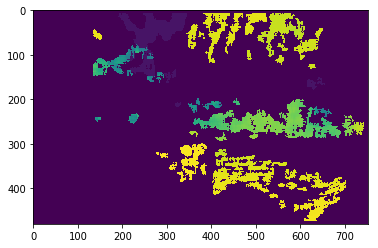

In [21]:
plt.imshow((X_all[0]).reshape((480,752)))

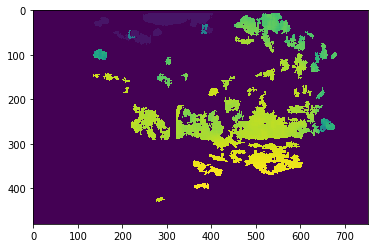

In [22]:
plt.imshow((X_all[600]).reshape((480,752)))

## Set up model and train

In [26]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (4,4), activation='relu', input_shape=(X_all.shape[1],X_all.shape[2], 1)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(4, (4,4), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    #
    keras.layers.Flatten(),  
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 477, 749, 16)      272       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 238, 374, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 119, 187, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 116, 184, 4)       1028      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 58, 92, 4)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 46, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5336)             

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.fit(X_all, y_all, validation_split=0.2, epochs=5, batch_size=8)

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 90s 157ms/step - loss: 0.5232 - accuracy: 0.7622 - val_loss: 0.4107 - val_accuracy: 0.8264
Epoch 2/5
572/572 [==============================] - 88s 155ms/step - loss: 0.3278 - accuracy: 0.8479 - val_loss: 0.3776 - val_accuracy: 0.8472
Epoch 3/5
572/572 [==============================] - 89s 155ms/step - loss: 0.2308 - accuracy: 0.9196 - val_loss: 0.4126 - val_accuracy: 0.8056
Epoch 4/5
572/572 [==============================] - 91s 159ms/step - loss: 0.1369 - accuracy: 0.9510 - val_loss: 0.4741 - val_accuracy: 0.8333
Epoch 5/5
572/572 [==============================] - 88s 154ms/step - loss: 0.0673 - accuracy: 0.9773 - val_loss: 0.4676 - val_accuracy: 0.8403


## Save model and weights

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("blocked_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("blocked_model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
model.predict(X_all[9].reshape((1,480,752,1)))

array([[0.9012154]], dtype=float32)

In [32]:
X_all[0].reshape((1,480,752,1))

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])